In [7]:
from PIL import Image
import torch
import numpy as np
import cv2
import albumentations as A
from torch.utils.data import Dataset
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import os.path as osp
import math
import json
import matplotlib.pyplot as plt


# dataset 지정 및 idx 
data_list=['/data/ephemeral/home/data/vietnamese_receipt', '/data/ephemeral/home/data/japanese_receipt', 
           '/data/ephemeral/home/data/thai_receipt','/data/ephemeral/home/data/chinese_receipt']

In [9]:
## 찾아보기
box_dict={}
for i in data_list:
    box_dict[i]={}
    dataset_dir = i

    ufo_fpath=osp.join(dataset_dir,'ufo/train.json')

    with open(ufo_fpath,'r') as f:
        ufo_anno=json.load(f)
    
    for j in sorted(ufo_anno['images']):
        result=[]
        for idx,val in enumerate(ufo_anno['images'][j]['words'].values()):
            for num in range(4):
                if num==0:
                    if abs(val['points'][num][0]-val['points'][3][0])<15 or abs(val['points'][num][0]-val['points'][1][0])<15:
                        pass
                    else:
                        result.append(f'{idx}')
                        break
                elif num==3:
                    if abs(val['points'][num][0]-val['points'][2][0])<15 or abs(val['points'][num][0]-val['points'][0][0])<15:
                        pass
                    else:
                        result.append(f'{idx}')
                        break
                else:
                    if abs(val['points'][num][0]-val['points'][num-1][0])<15 or abs(val['points'][num][0]-val['points'][num+1][0])<15:
                        pass
                    else:
                        result.append(f'{idx}')
                        break

        if len(result)>0:                
            box_dict[i][j]=result


In [10]:
for i,j in box_dict.items():
    print(i,len(j.keys()))

/data/ephemeral/home/data/vietnamese_receipt 21
/data/ephemeral/home/data/japanese_receipt 9
/data/ephemeral/home/data/thai_receipt 19
/data/ephemeral/home/data/chinese_receipt 52


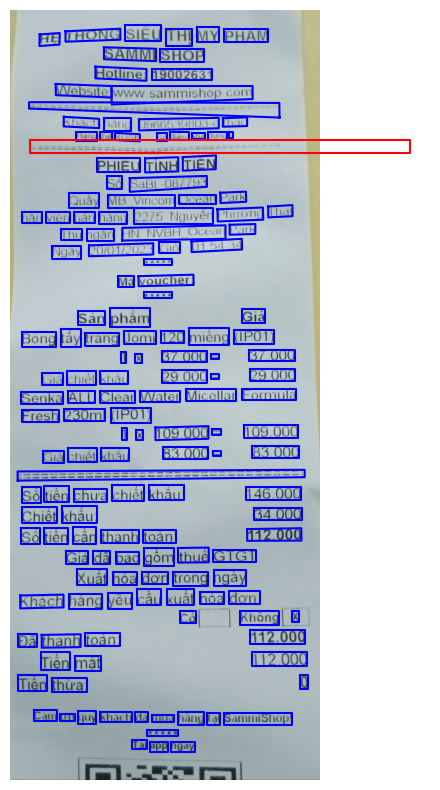

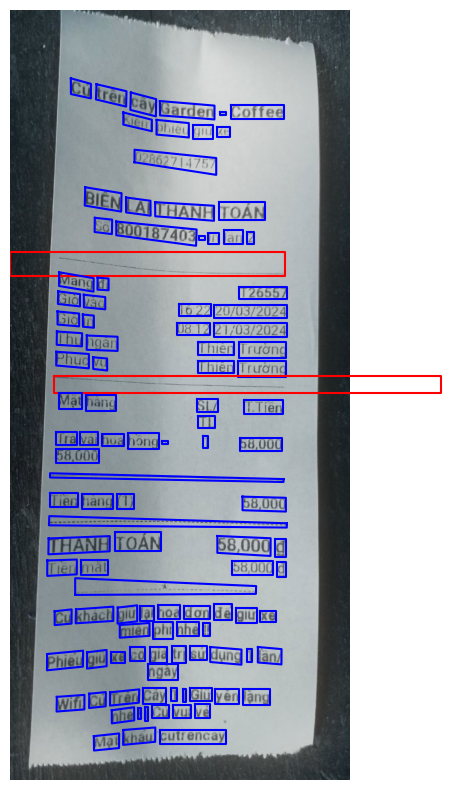

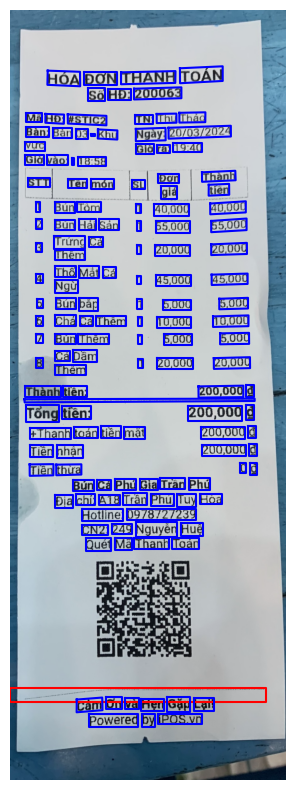

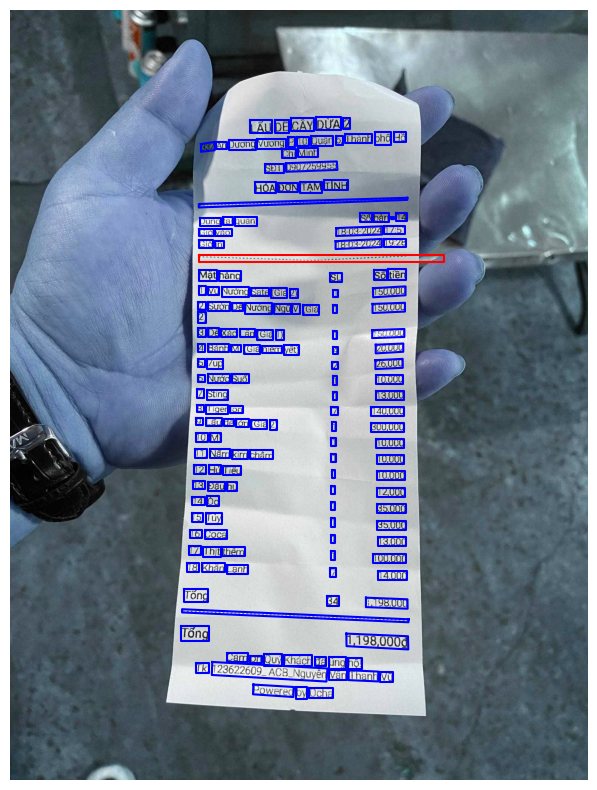

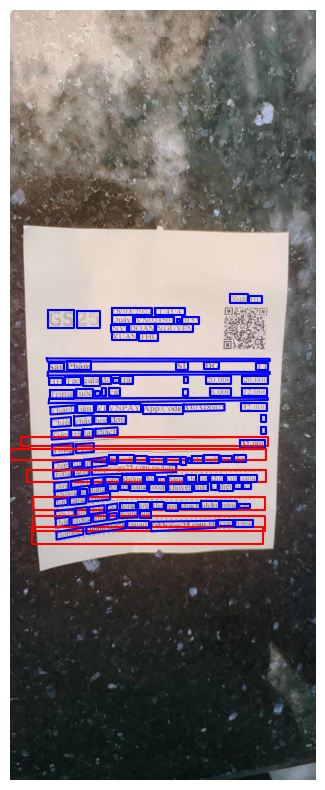

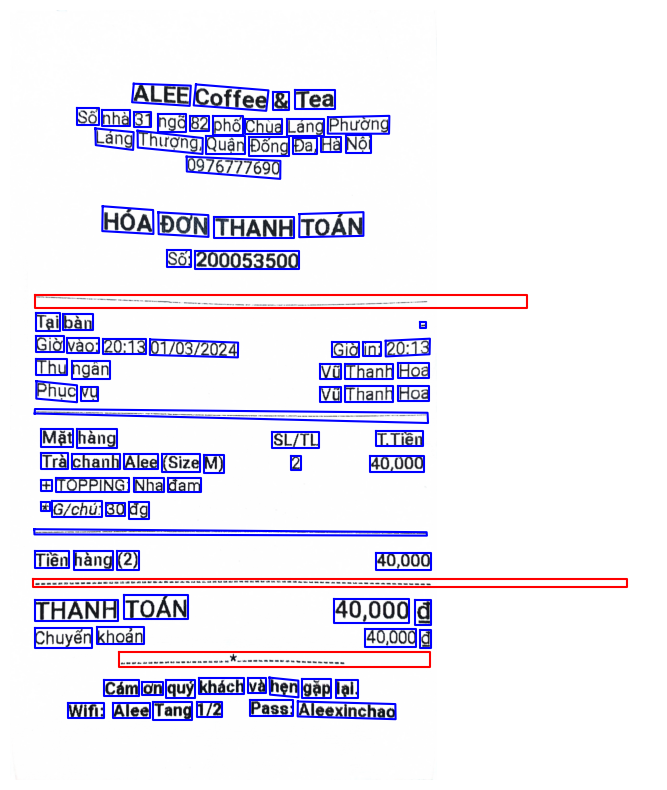

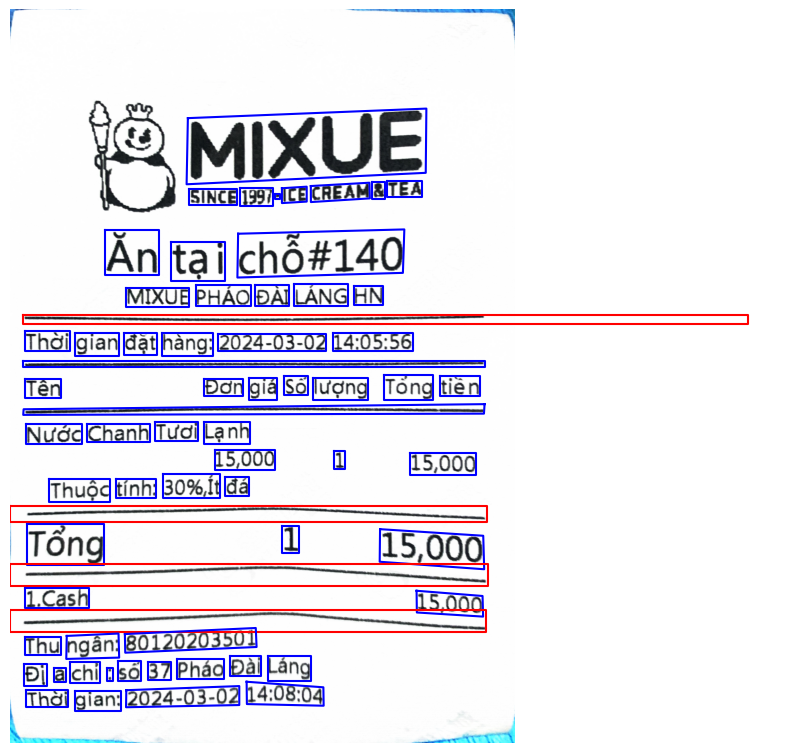

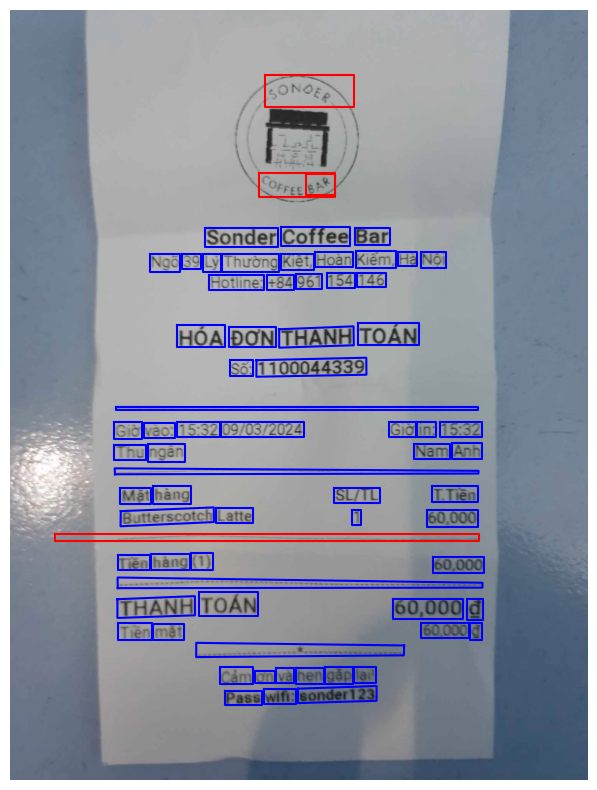

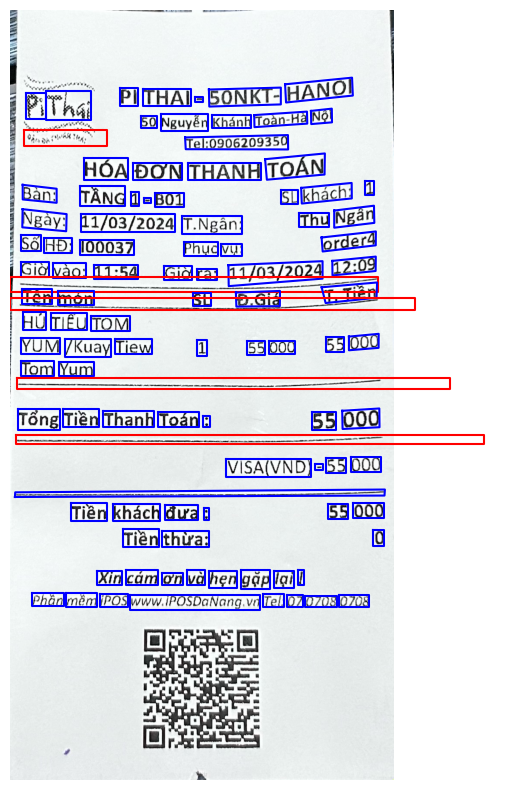

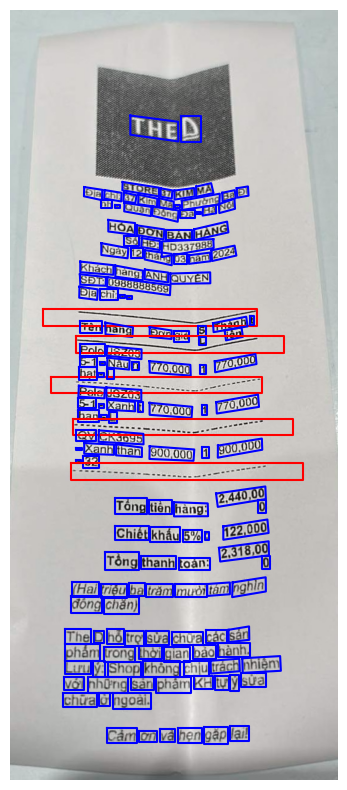

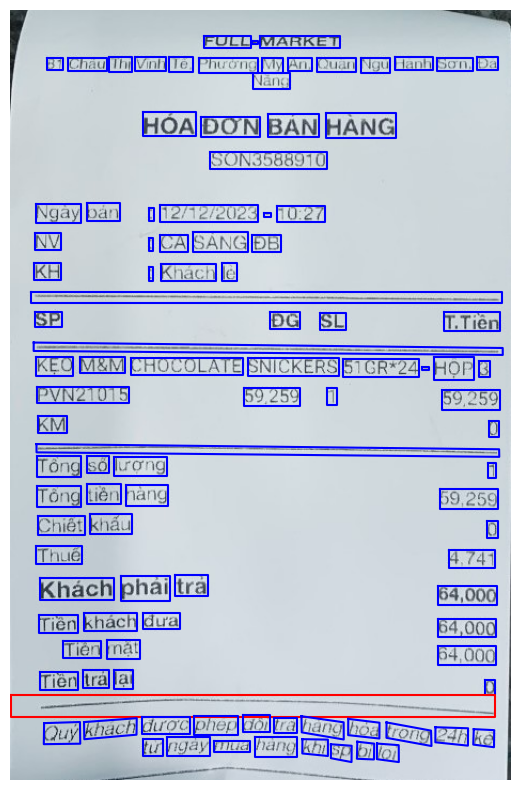

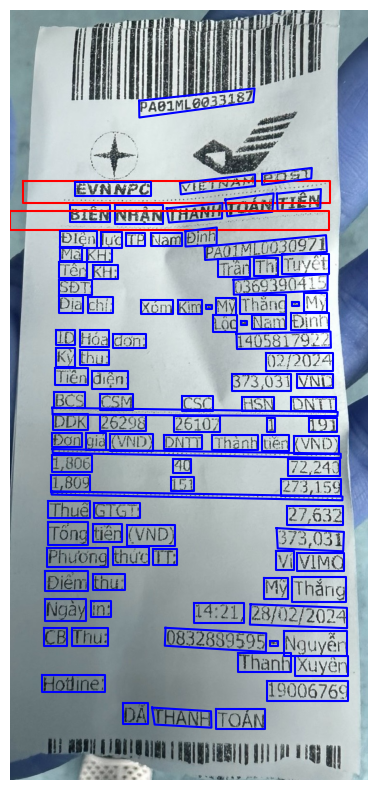

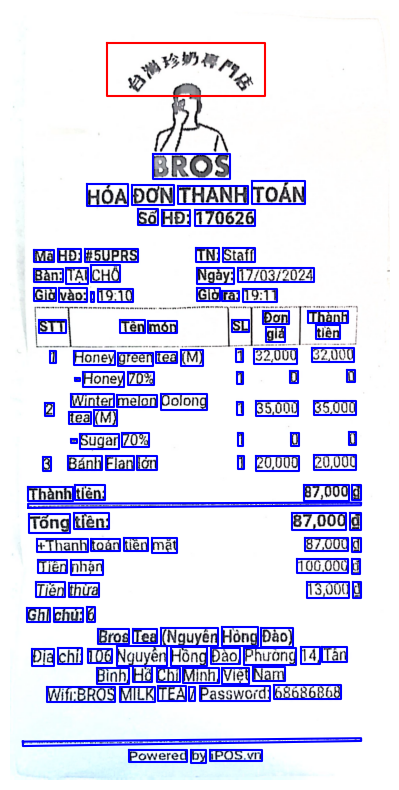

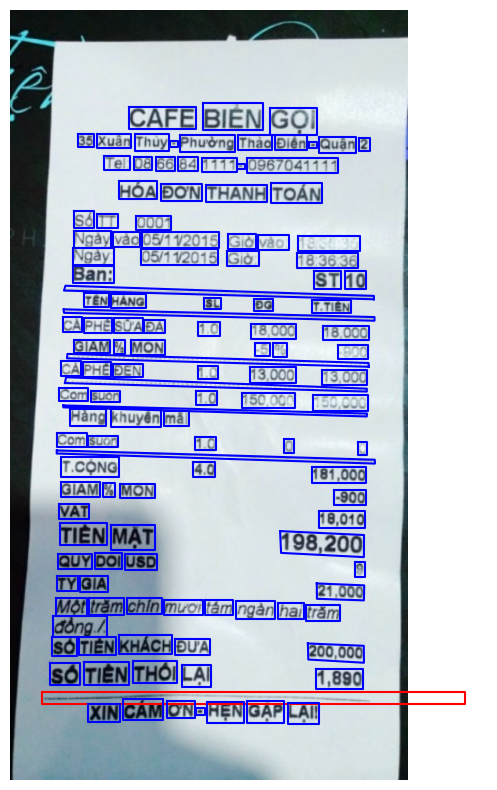

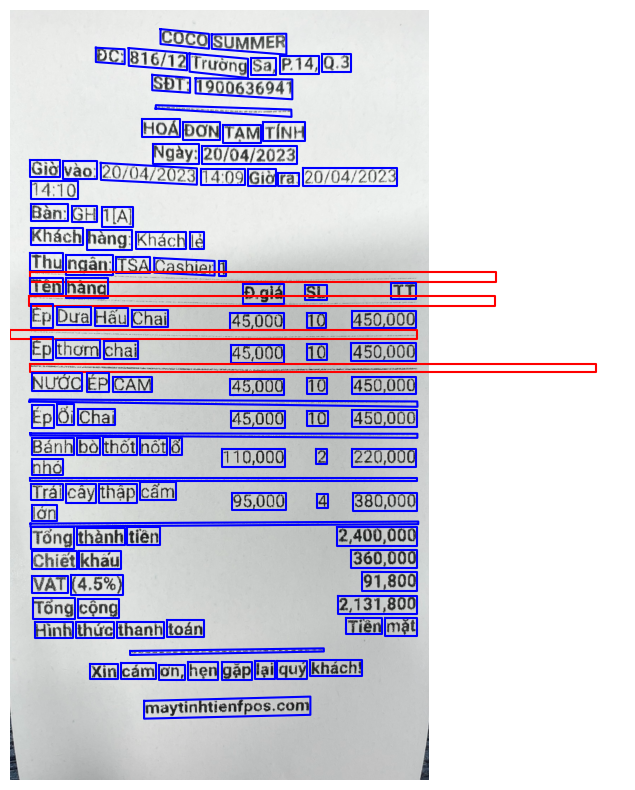

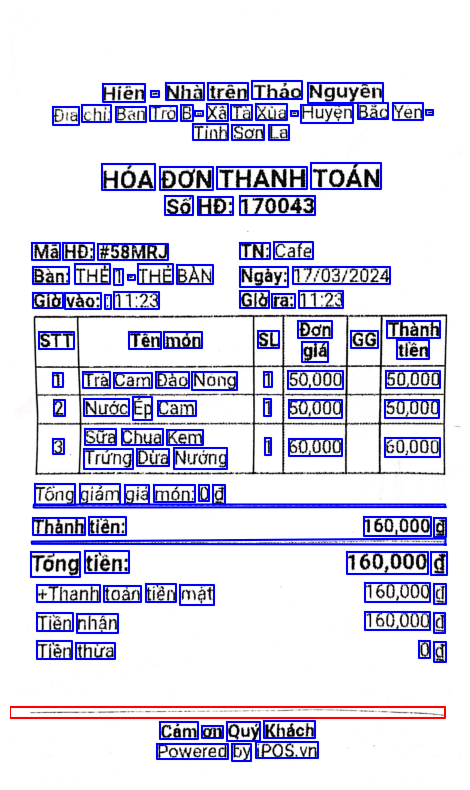

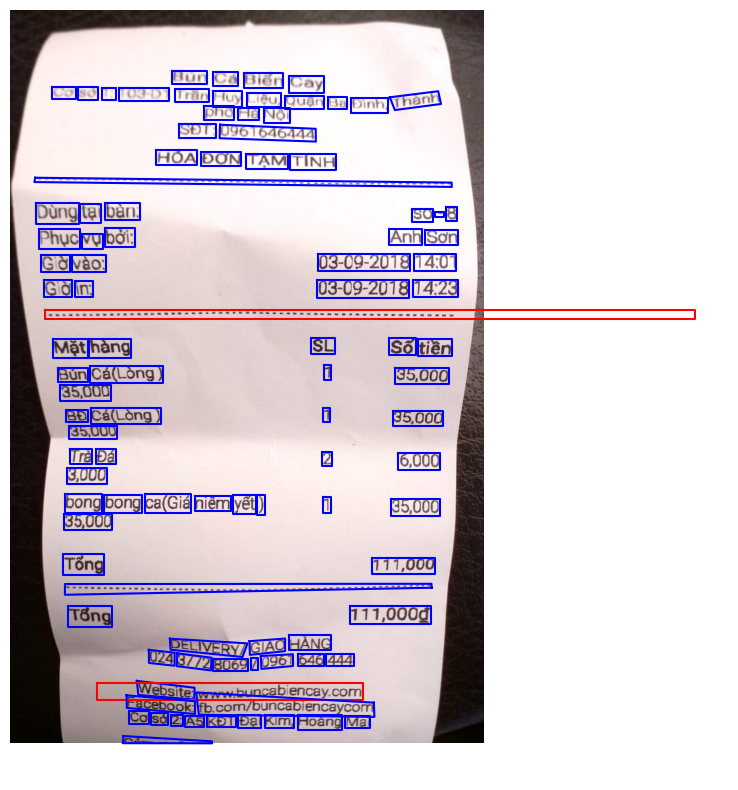

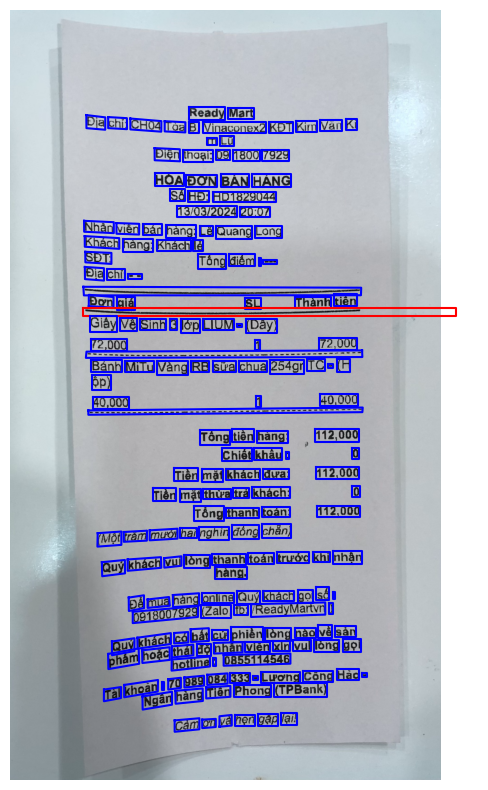

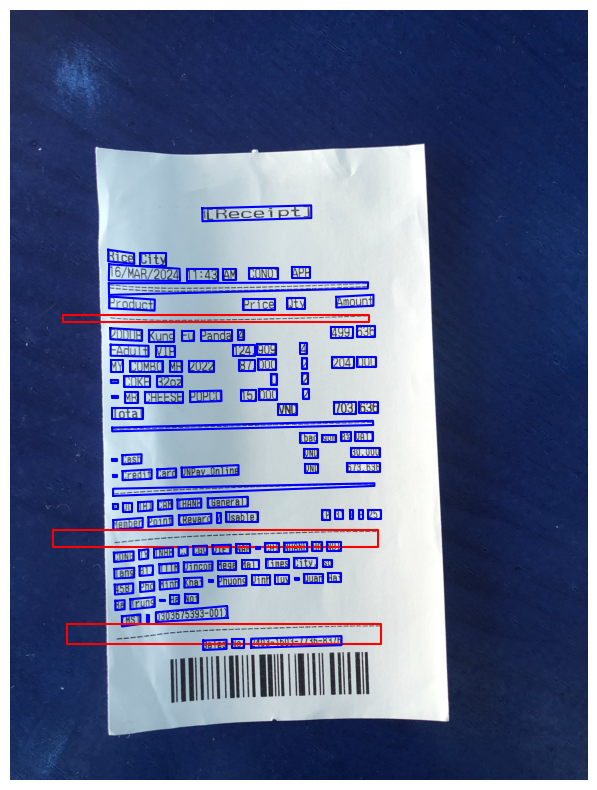

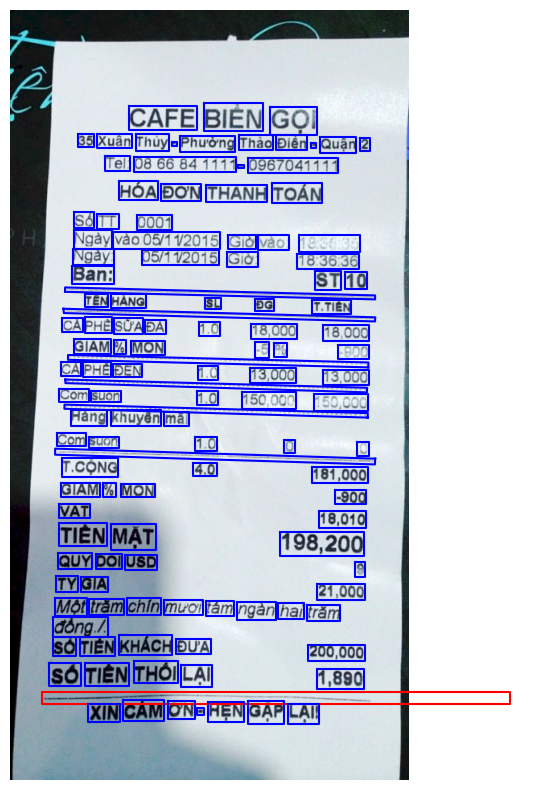

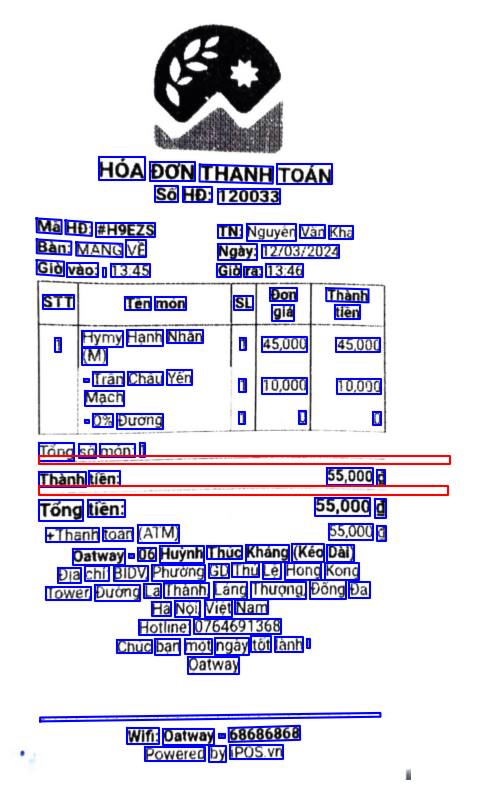

In [12]:
# dataset 지정 및 박스 위치 시각화

# '/data/ephemeral/home/data/vietnamese_receipt'
# '/data/ephemeral/home/data/japanese_receipt', 
# '/data/ephemeral/home/data/thai_receipt'
# '/data/ephemeral/home/data/chinese_receipt'
tmp=[]
dataset_dir = '/data/ephemeral/home/data/vietnamese_receipt'
for img,idx in box_dict[dataset_dir].items():


    #ufo_fpath=osp.join(dataset_dir,'ufo/train.json')
    ufo_fpath=osp.join('','/data/ephemeral/home/Seungcheol/level2-cv-datacentric-cv-07/EDA/Seungcheol/vietnamese_receipt.json')
    with open(ufo_fpath,'r') as f:
        ufo_anno=json.load(f)


    img_fpath=osp.join(dataset_dir,'img/train',img)
    image=cv2.imread(img_fpath)

    bboxes=[]
    for word_info in ufo_anno['images'][img]['words'].values():
        if len(word_info['points'])>4:
            continue

        bboxes.append(np.array(word_info['points']))
    bboxes=np.array(bboxes,dtype=np.float32)

    # 새 그림 생성
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")

    for i,word in enumerate(bboxes):
        if str(i) in idx:
            order=list(ufo_anno['images'][img]['words'].keys())
            tmp.append(ufo_anno['images'][img]['words'][order[i]]['transcription'])
            plt.plot(np.append(word[:,0],word[0,0]),np.append(word[:,1],word[0,1]), color="red")
        else:
            plt.plot(np.append(word[:,0],word[0,0]),np.append(word[:,1],word[0,1]), color="blue")
    plt.show()

In [5]:
## 이상한 박스들만 지워보기

for data in data_list:

    ufo_fpath=osp.join(data,'ufo/train.json')
    with open(ufo_fpath,'r') as f:
        ufo_anno=json.load(f)
    for img,idx in box_dict[data].items():
        ufo_anno['images'][img]['words']

        order=list(ufo_anno['images'][img]['words'].keys())

        for i in range(len(order)):
            if str(i) in idx:
                tmp = ufo_anno['images'][img]['words'][order[i]]['points']
                x_coords = [point[0] for point in tmp]
                y_coords = [point[1] for point in tmp]
                x_min=max(0.0, min(x_coords))
                x_max=max(x_coords)
                y_min=max(0.0, min(y_coords))
                y_max=max(y_coords)             
                ufo_anno['images'][img]['words'][order[i]]['points'] = [[x_min,y_min],[x_max,y_min],[x_max,y_max],[x_min,y_max]]
                
                # 새로운 JSON 파일로 저장하기
        nam=list(data.split('/'))[-1]
        with open(f'{nam}.json', 'w') as file:
            json.dump(ufo_anno, file, indent=4)  # indent=4는 들여쓰기 설정으로 가독성을 높임